In [19]:
import numpy as np
import simple_wta
import ahuja
import spectral_clustering
import kmeans_clustering
import regret_matching
import sap
from time import perf_counter
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams["font.family"] = ["serif"]
matplotlib.rcParams["font.serif"] = ["Times New Roman"]

In [20]:
# Problem Setup

# fix problem size to 200x200
# and cluster size to 15
n_w = 100
n_t = 100
n_c = 10

rng = np.random.RandomState(seed=42)

# generate random problems
probs = [simple_wta.random_wta_factory(n_w,n_t,rng) for i in range(100)]

# evaluate solutions with benchmark solver
x_ahuja = [ahuja.optimize(p) for p in probs]
c_ahuja = [probs[i].objective(x_ahuja[i]) for i in range(len(probs))]

In [21]:
# generate clusters for problems
cluster_data = [kmeans_clustering.reduce_problem(p,n_c,rng=rng) for p in probs]

In [22]:
# for each problem, run 100 iterations of regret matching
N = 300 
c1 = np.zeros((N,len(probs))) # data for storing cost of regret matching on large problem
c2 = np.zeros((N,len(probs))) # data for storing cost values of regret matching on sub problems
# data for storing calculations
for i in range(len(probs)):
    # initialize regret matching
    x = rng.choice(n_t,size=(n_w,))       # random action profile
    P = np.ones((n_w,n_t))/n_t            # uniform sampling distribution
    R = regret_matching.greedy_regret(probs[i]) # greedy regret
    c1[0,i] += probs[i].objective(x)
    for j in range(1,N):
        x,P,R = regret_matching.iterate(probs[i],R,P,x,j)
        c1[j,i] = probs[i].objective(np.argmax(P,axis=1))
    for k in range(n_c):
        prob = cluster_data[i][0][k]
        (n,m) = np.shape(prob.p)
        x = rng.choice(m,size=(n,))                 # random action profile
        P = np.ones((n,m))/m                        # uniform sampling distribution
        R = regret_matching.greedy_regret(prob)     # greedy regret
        c2[0,i] += prob.objective(x)
        for j in range(1,N):
            x,P,R = regret_matching.iterate(prob,R,P,x,j)
            c2[j,i] += prob.objective(np.argmax(P,axis=1))


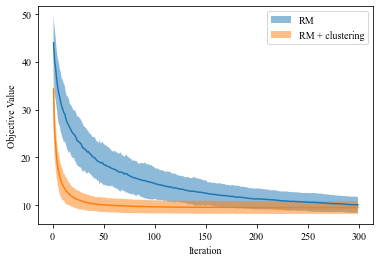

In [53]:
N=300
avg1 = np.average(c1[1:,:],axis=1)
std1 = np.std(c1[1:,:],axis=1)
avg2 = np.average(c2[1:,:],axis=1)
std2 = np.std(c2[1:,:],axis=1)
fig,axs = plt.subplots()
x = np.array(range(1,N))
axs.fill_between(x,avg1-2*std1,avg1+2*std1,alpha=.5,linewidth=0)
axs.fill_between(x,avg2-2*std2,avg2+2*std2,alpha=.5,linewidth=0)
axs.plot(x,avg1)
axs.plot(x,avg2)

# idx = 0
# while avg2[idx]>=avg1[-1]: idx += 1
# axs.axhline(y=avg1[-1],color="black",linestyle="dashed",linewidth=1,alpha=.5)
# axs.axvline(x=idx,color="black",linestyle="dashed",linewidth=1,alpha=.5)
# xticks = axs.get_xticks()
# xticks = xticks[1:-1]
# xticks[1] = idx
# yticks = axs.get_yticks()
# yticks = yticks[2:-2]
# yticks[0] = avg1[-1]
# axs.set_xticks(xticks)
# axs.set_yticks(yticks)
axs.legend(["RM", "RM + clustering"])
axs.set_xlabel("Iteration")
axs.set_ylabel("Objective Value")
plt.savefig("figures/multiagent_rl.png")

In [49]:
# for each problem, run 100 iterations of regret matching
N = 400
c3 = np.zeros((N,len(probs))) # data for storing cost of regret matching on large problem
c4 = np.zeros((N,len(probs))) # data for storing cost values of regret matching on sub problems
# data for storing calculations
for i in range(len(probs)):
    # initialize SAP
    x = rng.choice(n_t,size=(n_w,))       # random action profile
    P = np.ones((n_w,n_t))/n_t            # uniform sampling distribution
    c3[0,i] += probs[i].objective(x)
    tau = 1
    for j in range(1,N):
        tau = .02
        # print(tau)
        x,P = sap.iterate(probs[i],P,x,tau)
        c3[j,i] = probs[i].objective(np.argmax(P,axis=1))
    for k in range(n_c):
        prob = cluster_data[i][0][k]
        (n,m) = np.shape(prob.p) 
        x = rng.choice(m,size=(n,))                 # random action profile
        P = np.ones((n,m))/m                        # uniform sampling distribution
        c4[0,i] += prob.objective(x)
        for j in range(1,N):
            # tau = 1./j**2
            tau=.02
            x,P = sap.iterate(prob,P,x,tau)
            c4[j,i] += prob.objective(np.argmax(P,axis=1))

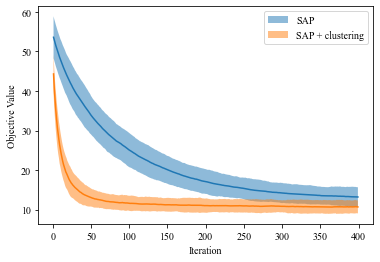

In [54]:
N=400
avg3 = np.average(c3[1:,:],axis=1)
std3 = np.std(c3[1:,:],axis=1)
avg4 = np.average(c4[1:,:],axis=1)
std4 = np.std(c4[1:,:],axis=1)
fig,axs = plt.subplots()
x = np.array(range(1,N))
axs.fill_between(x,avg3-2*std3,avg3+2*std3,alpha=.5,linewidth=0)
axs.fill_between(x,avg4-2*std4,avg4+2*std4,alpha=.5,linewidth=0)
axs.plot(x,avg3)
axs.plot(x,avg4)

# idx = 0
# while avg4[idx]>=avg3[-1]: idx += 1
# axs.axhline(y=avg3[-1],color="black",linestyle="dashed",linewidth=1,alpha=.5)
# axs.axvline(x=idx,color="black",linestyle="dashed",linewidth=1,alpha=.5)
# xticks = axs.get_xticks()
# xticks = xticks[1:-1]
# xticks[1] = idx
# yticks = axs.get_yticks()
# yticks = yticks[2:-2]
# yticks[0] = avg1[-1]
# axs.set_xticks(xticks)
# axs.set_yticks(yticks)
axs.legend(["SAP", "SAP + clustering"])
axs.set_xlabel("Iteration")
axs.set_ylabel("Objective Value")
plt.savefig("figures/multiagent_sap.png")

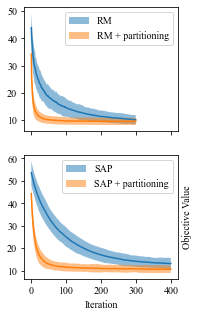

In [68]:
# Compound figure

fig,axs = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(2.75,5))
x = np.array(range(1,300))
axs[0].fill_between(x,avg1-2*std1,avg1+2*std1,alpha=.5,linewidth=0)
axs[0].fill_between(x,avg2-2*std2,avg2+2*std2,alpha=.5,linewidth=0)
axs[0].plot(x,avg1)
axs[0].plot(x,avg2)
axs[0].legend(["RM", "RM + partitioning"])
# axs[0].set_ylabel("Objective Value")
x = np.array(range(1,400))
axs[1].fill_between(x,avg3-2*std3,avg3+2*std3,alpha=.5,linewidth=0)
axs[1].fill_between(x,avg4-2*std4,avg4+2*std4,alpha=.5,linewidth=0)
axs[1].plot(x,avg3)
axs[1].plot(x,avg4)
axs[1].legend(["SAP", "SAP + partitioning"])
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Objective Value")
axs[1].yaxis.set_label_position("right")
plt.savefig("figures/multiagent_rl.png",dpi=1000)